In [16]:
import os
import pandas as pd
import numpy as np
import bisect
import pickle
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

# For ResNet
try:
  import timm
except:
  print('timm does not exist')
  !pip install timm
  import timm

try:
  import torchmetrics
except:
  !pip install torchmetrics
  import torchmetrics

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# 1.1 Data Preprocessing
- Resize images to 64x64
- Convert to grayscale
- Normalize to range [0, 1]
- Labels: {0: tops, 1: bottoms, 2: bags, 3: shoes, 4: others}
- Creates: X_train, X_test, y_train, y_test

In [2]:
data_paths = [os.path.join("dataset","train"), os.path.join("dataset","test")]
categories = ["tops", "bottoms", "bags", "shoes", "others"]
r1, r2 = 64, 64

X_data_train = []
y_data_train = []

X_data_test = []
y_data_test = []

for data_path in data_paths:
    for i, category in enumerate(categories):
        cat_path = os.path.join(data_path, category)
        for filename in os.listdir(cat_path):
            img_path = os.path.join(cat_path, filename)

            try:
                img = Image.open(img_path)
            except Exception as e:
                print(f"Error processing image '{img_path}': {e}")
                continue

            # Resize images
            img = img.resize((r1, r2)) 

            # Convert to black and white
            img = img.convert("L")

            # Normalize pixel values (0 to 1)
            img = np.array(img) / 255.0

            if "train" in data_path:
                # Flatten image and add to X_data
                X_data_train.append(img.flatten())
                # Add corresponding label to y_data
                y_data_train.append(i)

            elif "test" in data_path:
                X_data_test.append(img.flatten())
                y_data_test.append(i)

# Convert lists to np arrays
X_train = np.array(X_data_train)
y_train = np.array(y_data_train)

X_test = np.array(X_data_test)
y_test = np.array(y_data_test)

Error processing image 'dataset\train\bags\bag_0021': cannot identify image file 'dataset\\train\\bags\\bag_0021'
Error processing image 'dataset\train\bags\bag_0161': cannot identify image file 'dataset\\train\\bags\\bag_0161'
Error processing image 'dataset\train\bags\bag_0164': cannot identify image file 'dataset\\train\\bags\\bag_0164'
Error processing image 'dataset\train\bags\bag_0259': cannot identify image file 'dataset\\train\\bags\\bag_0259'
Error processing image 'dataset\train\bags\bag_0281': cannot identify image file 'dataset\\train\\bags\\bag_0281'
Error processing image 'dataset\train\others\other_0007': cannot identify image file 'dataset\\train\\others\\other_0007'
Error processing image 'dataset\train\others\other_0065': cannot identify image file 'dataset\\train\\others\\other_0065'


# 1.2 Data Preprocessing - PCA
- Creates: X_train_PCA, X_test_PCA

In [3]:
# PCA - exploring how many features to keep
pca_explore = PCA(random_state=1)
pca_explore.fit_transform(X_train)

array([[-3.48200406e+00,  8.04567809e+00, -3.74317092e-01, ...,
        -9.10218522e-04, -2.87504721e-03, -1.13206339e-03],
       [-1.08255461e+01,  4.14840135e+00,  5.34411497e-01, ...,
        -2.28426110e-03,  3.60898409e-03, -1.89292472e-03],
       [-1.17298902e+01,  4.05461449e+00,  1.04351244e+01, ...,
         2.77971582e-03, -3.48498502e-03, -9.56570418e-04],
       ...,
       [-3.16722082e+00, -7.87354319e+00,  2.91752315e+00, ...,
         2.14878846e-04, -2.32859850e-03, -9.40163377e-04],
       [ 1.45484147e+00, -6.03080248e+00,  2.54592430e+00, ...,
         1.83181836e-03, -2.32349299e-04, -1.55766968e-03],
       [-1.28709210e+00, -7.52373550e+00,  2.40153847e+00, ...,
         2.62991740e-03, -1.67604738e-03,  4.48197606e-03]])

In [4]:
PCA_THRESHOLD = 0.9
pca_cumulative_variances = np.cumsum(pca_explore.explained_variance_ratio_)

# bisect_left(array, value) returns the smallest idx such that array[idx] > value
# i.e. pca_cumulative_variances[pca_num_components] > PCA_THRESHOLD
pca_num_components = bisect.bisect_left(pca_cumulative_variances, PCA_THRESHOLD)

pca_num_components

100

In [5]:
# PCA - using the minimum number of components that are responsible for (PCA_THRESHOLD) amount of variance

pca = PCA(n_components=pca_num_components)
X_train_PCA = pca.fit_transform(X_train)
X_test_PCA = pca.transform(X_test)

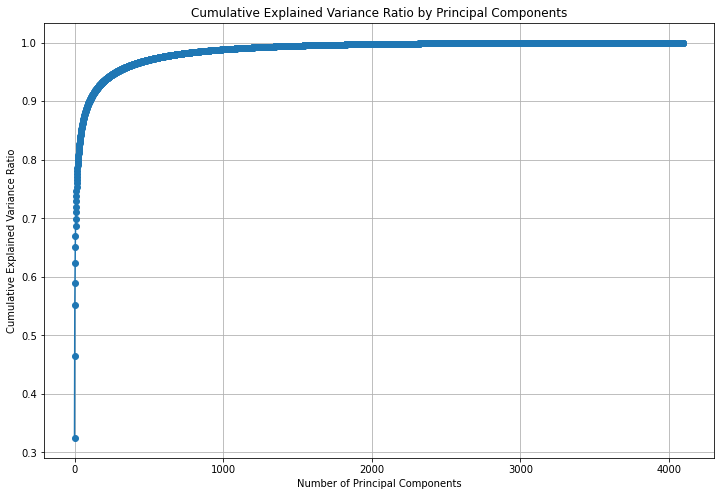

In [6]:
plt.figure(figsize=(12, 8), facecolor="white")
plt.plot(np.cumsum(pca_explore.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio by Principal Components')
plt.grid(True)
plt.show()

# 1.3 Visualising Preprocessed Data
X_train

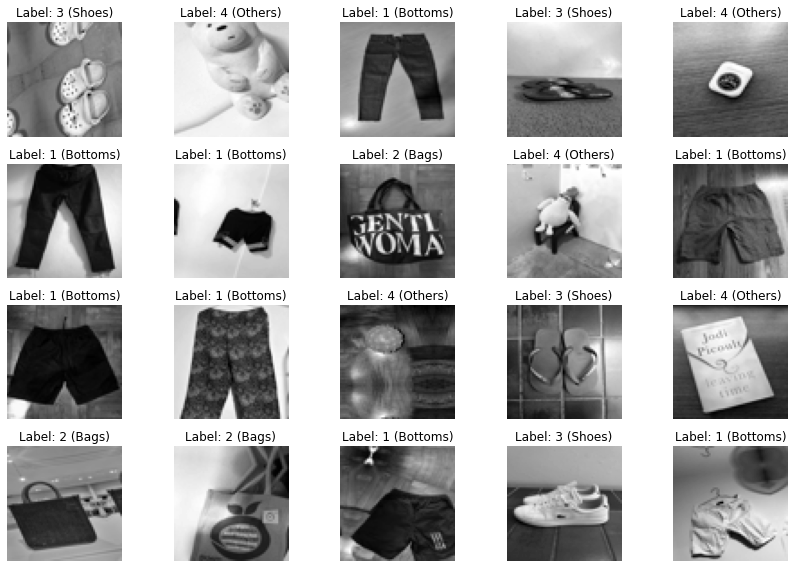

In [7]:
num_images = 20
num_rows = round(num_images / 5)
num_cols = num_images // num_rows

labels_dict = {0: "tops", 1: "bottoms", 2: "bags", 3: "shoes", 4: "others"}

# Get random indices to select images
random_indices = np.random.choice(len(X_train), num_images, replace=False)

# Visualize the images
plt.figure(figsize=(12, 8), facecolor="white")
for i, idx in enumerate(random_indices):
    # Reshape the flattened pixel values back to the original image shape
    image = X_train[idx].reshape(r1, r2)
    label = y_train[idx]
    
    # Plot the image
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f'Label: {label} ({labels_dict[label].capitalize()})')
    plt.axis('off')

plt.tight_layout()
plt.show()

X_train_PCA

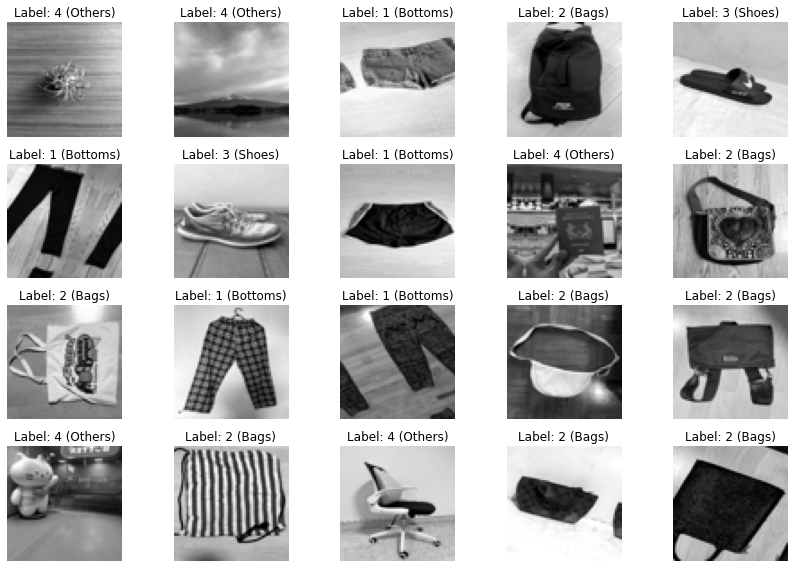

In [8]:
num_images = 20
num_rows = round(num_images / 5)
num_cols = num_images // num_rows

labels_dict = {0: "tops", 1: "bottoms", 2: "bags", 3: "shoes", 4: "others"}

# Get random indices to select images
random_indices = np.random.choice(len(X_train_PCA), num_images, replace=False)

# Visualize the images
plt.figure(figsize=(12, 8), facecolor="white")
for i, idx in enumerate(random_indices):
    # Reshape the flattened pixel values back to the original image shape
    image = X_train[idx].reshape(r1, r2)
    label = y_train[idx]
    
    # Plot the image
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f'Label: {label} ({labels_dict[label].capitalize()})')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Model 1: ResNet

In [9]:
class customDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X.reshape((-1,64,64,1))
        self.y = y.reshape(-1,1)
        self.transform = transform
    
    def __getitem__(self, index):
        X = self.X[index]
        y = self.y[index]

        if self.transform:
            X = self.transform(X)
        
        return X, y
    
    def __len__(self):
        return len(self.X)

In [10]:
# Split training data into train and validation sets
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, random_state=1, test_size=0.2)

# Define dataset objects
transform = transforms.Compose([transforms.ToTensor()])

ds_train = customDataset(X_tr, y_tr, transform=transform)
ds_val = customDataset(X_val, y_val, transform=transform)
ds_test = customDataset(X_test, y_test, transform=transform)

# Create Dataset Loaders
batch_size = 32
train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(ds_val, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(ds_test, batch_size=batch_size, shuffle=True)

In [11]:
timm_model = timm.create_model(model_name="resnet50", pretrained=True, num_classes=5, in_chans=1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.Adam(timm_model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
accuracy_fn = torchmetrics.Accuracy(task="multiclass", num_classes=5).to(device)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [12]:
def train_step(model, dataloader, optimizer, loss_fn, accuracy_fn, device):
    
    train_loss, train_acc = 0, 0
    all_preds, all_targets = [], []

    model.to(device)
    model.train()

    for i, (X, y) in enumerate(dataloader):

        # Push to device (cuda)
        X, y = X.to(device), y.to(device)
        # Zero gradients
        optimizer.zero_grad()
        # Feedforward
        logits = model(X.float())
        # Compute loss
        loss = loss_fn(logits, y.long().squeeze())
        # Backpropagation
        loss.backward()
        # Update weights
        optimizer.step()

        train_loss += loss.item()
        y_preds = logits.argmax(dim=1)
        train_acc += accuracy_fn(y_preds, y.long().squeeze()).item()

        all_preds += [y_preds]
        all_targets += [y.long().squeeze()]

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {100* train_acc:.2f}%")
    return train_loss, train_acc, all_preds, all_targets

def test_step(model, dataloader, loss_fn, accuracy_fn, device):

    test_loss, test_acc = 0, 0
    all_preds, all_targets = [], []

    model.to(device)
    model.eval()

    with torch.inference_mode():
        for i, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            logits = model(X.float())
            loss = loss_fn(logits, y.long().squeeze())

            test_loss += loss.item()
            y_preds = logits.argmax(dim=1)
            test_acc += accuracy_fn(y_preds, y.long().squeeze()).item()

            all_preds += [y_preds]
            all_targets += [y.long().squeeze()]

        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {100* test_acc:.2f}%")

    return test_loss, test_acc, all_preds, all_targets

In [13]:
epochs = 20
best_val_loss = float("inf")
early_stopping_counter = 0
early_stopping_threshold = 5

for epoch in range(epochs):
    print("-"*50 + f" Current epoch: {epoch + 1} " + "-"*50)
    train_loss, train_acc, train_preds, train_targets = train_step(
        model=timm_model,
        dataloader=train_loader,
        optimizer=optimizer,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

    val_loss, val_acc, val_preds, val_targets = test_step(
        model=timm_model,
        dataloader=val_loader,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

    scheduler.step()

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
        torch.save(timm_model.state_dict(), "models/resnet_best_model.pth")  # Save the best model
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_threshold:
            print("Early Stopping Triggered")
            break

-------------------------------------------------- Current epoch: 1 --------------------------------------------------
Train loss: 0.47130 | Train accuracy: 83.39%
Test loss: 0.14646 | Test accuracy: 95.49%
-------------------------------------------------- Current epoch: 2 --------------------------------------------------
Train loss: 0.11738 | Train accuracy: 96.13%
Test loss: 0.06901 | Test accuracy: 97.54%
-------------------------------------------------- Current epoch: 3 --------------------------------------------------
Train loss: 0.05274 | Train accuracy: 98.52%
Test loss: 0.06078 | Test accuracy: 98.05%
-------------------------------------------------- Current epoch: 4 --------------------------------------------------
Train loss: 0.04710 | Train accuracy: 98.58%
Test loss: 0.06828 | Test accuracy: 98.05%
-------------------------------------------------- Current epoch: 5 --------------------------------------------------
Train loss: 0.03076 | Train accuracy: 99.07%
Test los

Test Results using Best ResNet Model

In [14]:
model_path = "models/resnet_best_model.pth"
timm_model = timm.create_model(model_name="resnet50", num_classes=5, in_chans=1)
timm_model.load_state_dict(torch.load(model_path))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.Adam(timm_model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
accuracy_fn = torchmetrics.Accuracy(task="multiclass", num_classes=5).to(device)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

test_loss, test_acc, test_preds, test_targets = test_step(
        model=timm_model,
        dataloader=test_loader,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

Test loss: 0.35912 | Test accuracy: 91.18%


              precision    recall  f1-score   support

           0     1.0000    0.7500    0.8571        60
           1     0.9091    1.0000    0.9524        60
           2     0.7391    0.9714    0.8395        35
           3     0.9833    0.9833    0.9833        60
           4     0.9286    0.8667    0.8966        30

    accuracy                         0.9143       245
   macro avg     0.9120    0.9143    0.9058       245
weighted avg     0.9276    0.9143    0.9137       245



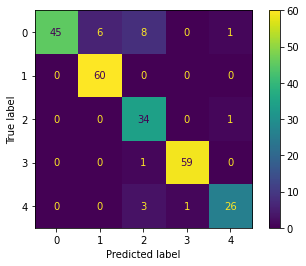

In [20]:
test_preds_list = [pred.item() for batch_preds in test_preds for pred in batch_preds]
test_targets_list = [target.item() for batch_targets in test_targets for target in batch_targets]

report = classification_report(test_targets_list, test_preds_list, digits=4)
print(report)

resnet_cm = confusion_matrix(test_targets_list, test_preds_list)
ConfusionMatrixDisplay(confusion_matrix=resnet_cm).plot()